In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import time

import valez_finite_VI_lib as vi
from data_set_lib import DataSet
import generic_optimization_lib as packing

In [2]:
#np.random.seed(12321)

alpha = 10 # IBP parameter

num_samples = 50 # sample size
D = 2 # dimension

sigma_a = 3.0 ** 2

sigma_eps = 1.0 ** 2 # variance of noise

k_inf = 3 # take to be large for a good approximation to the IBP

pi, Z, mu, A, X = vi.generate_data(num_samples, D, k_inf, sigma_a, sigma_eps, alpha)

k_approx = k_inf # variational truncation

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(num_samples, D, k_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_a, sigma_eps)

data_set = DataSet(X, k_approx, alpha, sigma_eps, sigma_a)

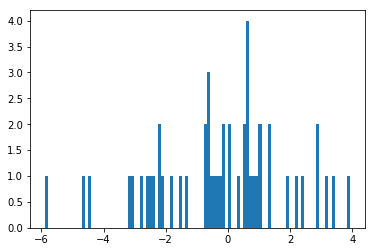

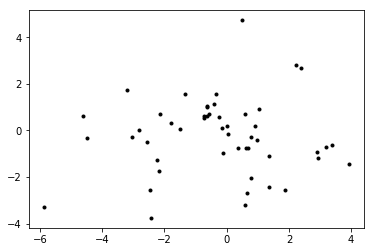

In [3]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [4]:
# Parameters approximating the true distribution

tau_true = np.zeros_like(tau_init)
tau_true_scale = 15.
tau_true[:, 0] = deepcopy(pi) * tau_true_scale
tau_true[:, 1] = tau_true_scale

nu_true = np.zeros_like(nu_init)
nu_true[Z == 1] = 0.999
nu_true[Z == 0] = 0.001

phi_mu_true = np.zeros_like(phi_mu_init)
phi_mu_true[:] = A.transpose()
phi_var_true = np.zeros_like(phi_var_init)
phi_var_true[:] = 0.01

params_true = packing.pack_params(deepcopy(tau_true), deepcopy(phi_mu_true),
                                  deepcopy(phi_var_true), deepcopy(nu_true))

In [5]:
true_init = False
if true_init:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_true)
else:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_init)

tau, nu, phi_mu, phi_var = data_set.run_cavi(tau, nu, phi_mu, phi_var, max_iter=100, tol=1e-6)

cavi_tau = deepcopy(tau)
cavi_phi_mu = deepcopy(phi_mu)
cavi_phi_var = deepcopy(phi_var)
cavi_nu = deepcopy(nu)

Step 0 objective: 41.5780858898
Step 10 objective: 0.676431230231
Step 20 objective: 0.299375589172
Step 30 objective: 0.188194247267
Step 40 objective: 0.0760444242606
Step 50 objective: 0.0332326824101
Step 60 objective: 0.0228314996735
Step 70 objective: 0.0347292941911
Step 80 objective: 0.0920327160079
Step 90 objective: 0.297684988517
Done with CAVI.


In [6]:
# CAVI can return nu values that are too close to 0 or 1 for the encoding.
nu_tol = 1e-8
cavi_nu_trim = deepcopy(cavi_nu)
cavi_nu_trim[cavi_nu_trim < nu_tol] = nu_tol
cavi_nu_trim[cavi_nu_trim > 1 - nu_tol] = 1 - nu_tol

cavi_params = packing.pack_params(cavi_tau, cavi_phi_mu, cavi_phi_var, cavi_nu_trim)
print np.all(np.isfinite(cavi_params))

True


In [7]:
data_set.trace.reset()
vb_opt = data_set.run_newton_tr(cavi_params, maxiter=50, gtol=1e-2)
tr_params = deepcopy(vb_opt.x)
tr_tau, tr_phi_mu, tr_phi_var, tr_nu = data_set.unpack_params(tr_params)


Step 0 objective: -50.8656202753
Optimization terminated successfully.
         Current function value: -50.884758
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
         Hessian evaluations: 0
Done with Newton trust region.


In [8]:
print 'CAVI:'
print cavi_phi_mu.transpose()

print 'Full TR:'
tau, phi_mu, phi_var, nu = data_set.unpack_params(tr_params)
print phi_mu.transpose()

print 'Truth:'
print A

CAVI:
[[ 0.81315875  3.63510986]
 [ 1.78703409 -1.51123864]
 [-3.67810722 -0.76061231]]
Full TR:
[[ 0.82465142  3.6286426 ]
 [ 1.77641749 -1.50667871]
 [-3.69634944 -0.73376719]]
Truth:
[[ 0.11374193 -3.1534841 ]
 [-2.84509969  1.09534115]
 [ 2.45285567  2.18308503]]


Cavi residuals: 66.5591204752    Trust residuals: 66.3803048198      True residuals: 79.8171999373


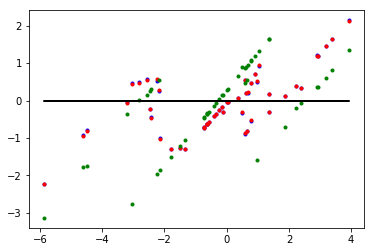

In [9]:
cavi_resid = data_set.x - data_set.get_prediction(cavi_params)
tr_resid = data_set.x - data_set.get_prediction(tr_params)
true_resid = data_set.x - np.matmul(Z, A)

plt.figure()
col = 0
plt.plot(data_set.x[:, col], tr_resid[:, col], '.b')
plt.plot(data_set.x[:, col], cavi_resid[:, col], '.r')
plt.plot(data_set.x[:, col], true_resid[:, col], '.g')
plt.plot(data_set.x[:, col], np.full_like(data_set.x[:, col], 0.), 'k')

print('Cavi residuals: {}    Trust residuals: {}      True residuals: {}'.format(
       np.sum(np.abs(cavi_resid)), np.sum(np.abs(tr_resid)), np.sum(np.abs(true_resid))))


In [10]:
def get_moments(params, data_set):
    # Return moments of interest.
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params)
    e_log_pi, e_log_pi2, e_mu, phi_moment2, nu_moment = \
        vi.get_moments(tau, nu, phi_mu, phi_var)
    return e_log_pi, e_mu

def get_moments_vector(params, data_set):
    e_log_pi, e_mu = get_moments(params, data_set)
    return packing.pack_moments(e_log_pi, e_mu)

get_moments_vector_jac = jacobian(get_moments_vector)

jac_time = time.time()
moment_jac = get_moments_vector_jac(tr_params, data_set)
jac_time = time.time() - jac_time
print jac_time

par_hp_hess_time = time.time()
par_hp_hess = data_set.get_kl_sens_hess(tr_params, hyper_params)
par_hp_hess_time = time.time() - par_hp_hess_time


0.00756001472473


In [11]:
hess_time = time.time()
kl_hess = data_set.get_kl_hessian(tr_params)
hess_time = time.time() - hess_time
kl_hess_eigvals = np.linalg.eigvals(kl_hess)
print hess_time

0.910593986511


In [12]:
print np.max(kl_hess_eigvals)
print np.min(kl_hess_eigvals)

25.4657047136
2.59224823921e-08


In [13]:
# Eq. 18 from our paper.  The -1 comes from the fact that par_hp_hess is of the
# KL divergence, not the expected log probability.
sensitivity_operator = -1 * np.linalg.solve(kl_hess, par_hp_hess.T)
moment_sensitivity = np.matmul(moment_jac, sensitivity_operator)

print(moment_sensitivity)

[[  4.95378906e-02  -2.94609017e-03  -2.89413171e-03]
 [  2.04302937e-02   2.63037643e-03  -3.13469861e-01]
 [  1.87154254e-02  -2.31834495e-04  -2.15532812e-02]
 [ -1.94149068e-02  -1.02777850e-02   1.36526954e+00]
 [ -5.13851695e-03   2.36873127e-03  -2.59712947e-01]
 [ -4.09730024e-03  -6.35217410e-03   4.64841670e-01]
 [  2.39543864e-03   3.40357035e-02  -1.59592562e+00]
 [  8.35599015e-03  -2.82997247e-03   1.57159762e-01]
 [ -2.69753655e-03   4.36594507e-03  -1.10888230e-01]]


In [14]:
# The third column is sigma_eps.

sigma_eps_col = 2
e_log_pi_sigma_eps_sens, e_mu_sigma_eps_sens = \
    packing.unpack_moments(moment_sensitivity[:, sigma_eps_col], k_approx, D)
    
print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

Sensitivity of e_log_pi to sigma_eps:
[-0.00289413 -0.31346986 -0.02155328]
Sensitivity of e_mu to sigma_eps:
[[ 1.36526954 -0.25971295  0.46484167]
 [-1.59592562  0.15715976 -0.11088823]]


In [15]:
# Perturb and re-rerun to check the sensitivity.

epsilon = 1e-1
data_set_perturb = DataSet(X, k_approx, alpha, sigma_eps + epsilon, sigma_a)
data_set_perturb.trace.print_every = 1
vb_opt_perturb = data_set_perturb.run_newton_tr(tr_params)

Step 0 objective: -39.5982815817
Step 1 objective: -39.6689336971
Step 2 objective: -39.6711457819
Step 3 objective: -39.7022969095
Step 4 objective: -39.7208538183
Step 5 objective: -39.7280851541
Step 6 objective: -39.7328794085
Step 7 objective: -39.7332171406
Step 8 objective: -39.7338162919
Step 9 objective: -39.7344967261
Step 10 objective: -39.7348314438
Step 11 objective: -39.7345991696
Step 12 objective: -39.7350942448
Step 13 objective: -39.7351142006
Step 14 objective: -39.7351593834
Step 15 objective: -39.7351761463
Step 16 objective: -39.7351829
Step 17 objective: -39.735191761
Step 18 objective: -39.7351963253
Step 19 objective: -39.7351970455
Step 20 objective: -39.7351978609
Step 21 objective: -39.7351983759
Step 22 objective: -39.7351984068
Optimization terminated successfully.
         Current function value: -39.735198
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 21
         Hessian evaluations: 0
Done with Newton trust reg

In [16]:
e_log_pi, e_mu = get_moments(tr_params, data_set)
e_log_pi_perturb, e_mu_perturb = get_moments(vb_opt_perturb.x, data_set)

print('Measured sensitivity of e_mu to sigma_eps:')
print((e_mu_perturb - e_mu) / epsilon)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

print('Measured sensitivity of e_log_pi to sigma_eps:')
print((e_log_pi_perturb - e_log_pi) / epsilon)

print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)

Measured sensitivity of e_mu to sigma_eps:
[[ 1.24075624 -0.23673572  0.49970306]
 [-1.58209174  0.12153249 -0.11335899]]
Sensitivity of e_mu to sigma_eps:
[[ 1.36526954 -0.25971295  0.46484167]
 [-1.59592562  0.15715976 -0.11088823]]
Measured sensitivity of e_log_pi to sigma_eps:
[-0.00170424 -0.33789747 -0.02903424]
Sensitivity of e_log_pi to sigma_eps:
[-0.00289413 -0.31346986 -0.02155328]
